### 12.2.2 CNN을 이용한 NLTK 영화 리뷰 분류

In [1]:
from nltk.corpus import movie_reviews
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

# movie review data에서 file id를 가져옴
fileids = movie_reviews.fileids()

# file id를 이용해 raw text file을 가져옴
reviews = [ movie_reviews.raw(fileid) for fileid in fileids ]
categories = [ movie_reviews.categories(fileid)[0] for fileid in fileids ]

np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000  # 사용할 단어의 수
maxlen = 500  # 문서의 단어 수를 제한

# 빈도가 높은 10000개의 단어를 선택하도록 객체 생성
tokenizer = Tokenizer(num_words = max_words, oov_token='UNK')
tokenizer.fit_on_texts(reviews)  # 단어 인덱스 구축

X = tokenizer.texts_to_sequences(reviews)  # 만들어진 단어 인덱스를 이용해 반환
X = pad_sequences(X, maxlen=maxlen, padding='pre')

# label을 0, 1의 값으로 변환
label_dict = {'pos':0, 'neg':1}
y = np.array([ label_dict[c] for c in categories ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

d:\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
d:\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Embedding, Flatten, Dropout
from keras.optimizers import Adam

model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=maxlen),
    Conv1D(
        filters=128,
        kernel_size=5,  
        padding='valid',
        activation='relu',
        strides=1
    ),
    MaxPooling1D(pool_size=2),
    Conv1D(
        filters=256,
        kernel_size=5,
        padding='valid',
        activation='relu',
        strides=1
    ),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # binary logistic regression
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 496, 128)          41088     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 248, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 244, 256)          164096    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 122, 256)         0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 31232)             0

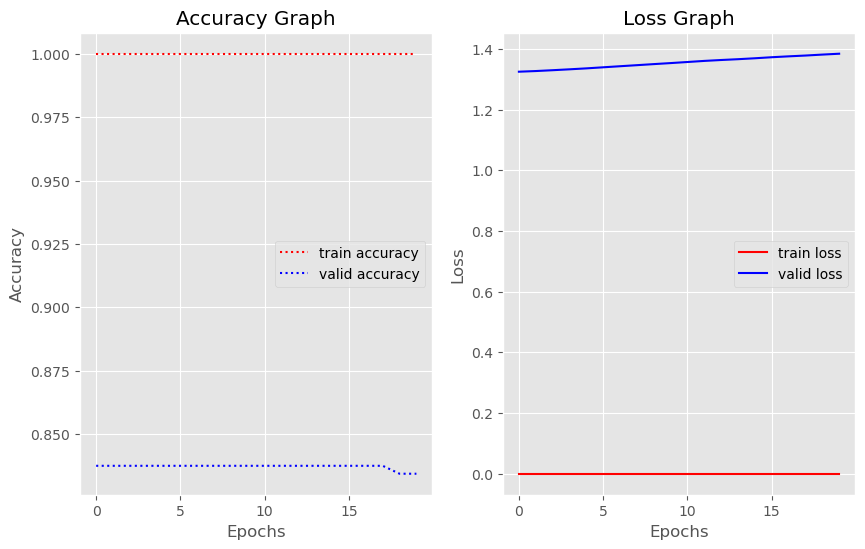

In [6]:
adam = Adam(learning_rate=1e-3)
model.compile(
    optimizer = adam,
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 256,
    validation_split = 0.2,
    verbose=0
)

import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(history.history['acc'], 'r:',label='train accuracy')
ax1.plot(history.history['val_acc'], 'b:',label='valid accuracy')
ax1.legend()
ax1.set_title('Accuracy Graph')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(history.history['loss'], 'r-', label='train loss')
ax2.plot(history.history['val_loss'], 'b-', label='valid loss')
ax2.legend()
ax2.set_title('Loss Graph')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

plt.show();

In [7]:
score = model.evaluate(X_test, y_test)
print("Test accuracy : {:.3f}".format(score[1]))

13/13 [==============================] - 1s 46ms/step - loss: 1.2652 - acc: 0.8200
Test accuracy : 0.820
